In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(512, 512, bias=True),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(512, 10, bias=True),
            nn.Softmax(dim=1)
        )

        self.dropout = nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [2]:
def neural_cleanse(model, data_loader, target_class, num_classes=10, input_shape=(1, 28, 28), lambda_reg=0.01, lr=0.01, momentum=0.99, num_epochs=10):

    pattern = torch.ones(input_shape, requires_grad=True, device='cuda')
    mask = torch.ones(input_shape, requires_grad=True, device='cuda')


    model = model.to('cuda')

    optimizer = optim.SGD([pattern, mask], lr=lr, momentum=momentum)


    def loss_function(output, target, mask, pattern):

        classification_loss = nn.CrossEntropyLoss()(output, target)


        regularization_term = lambda_reg * torch.sum(torch.abs(mask))

        return classification_loss + regularization_term

    # Optimization loop
    for epoch in range(num_epochs):
        for inputs, _ in data_loader:
            inputs = inputs.to('cuda')

            # Apply the mask and pattern to the inputs
            modified_inputs = inputs + mask * pattern

            # Forward pass
            outputs = model(modified_inputs)

            # Target labels (all set to the target class)
            target_labels = torch.full((inputs.size(0),), target_class, dtype=torch.long, device='cuda')

            # Compute the loss
            loss = loss_function(outputs, target_labels, mask, pattern)

            # Clamp mask and pattern to be within [0, 1]
            mask.data = torch.clamp(mask, 0, 1)
            pattern.data = torch.clamp(pattern, 0, 1)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return mask, pattern


In [ ]:
masks = []
patterns = []

model = MyModel()

model_path = '/content/poisened_model_4.pth'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model = model.to('cuda')
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
data_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=False)

for target_class in range(10):
    mask, pattern = neural_cleanse(model, data_loader, target_class)
    masks.append(mask.cpu().detach().numpy())
    patterns.append(pattern.cpu().detach().numpy())



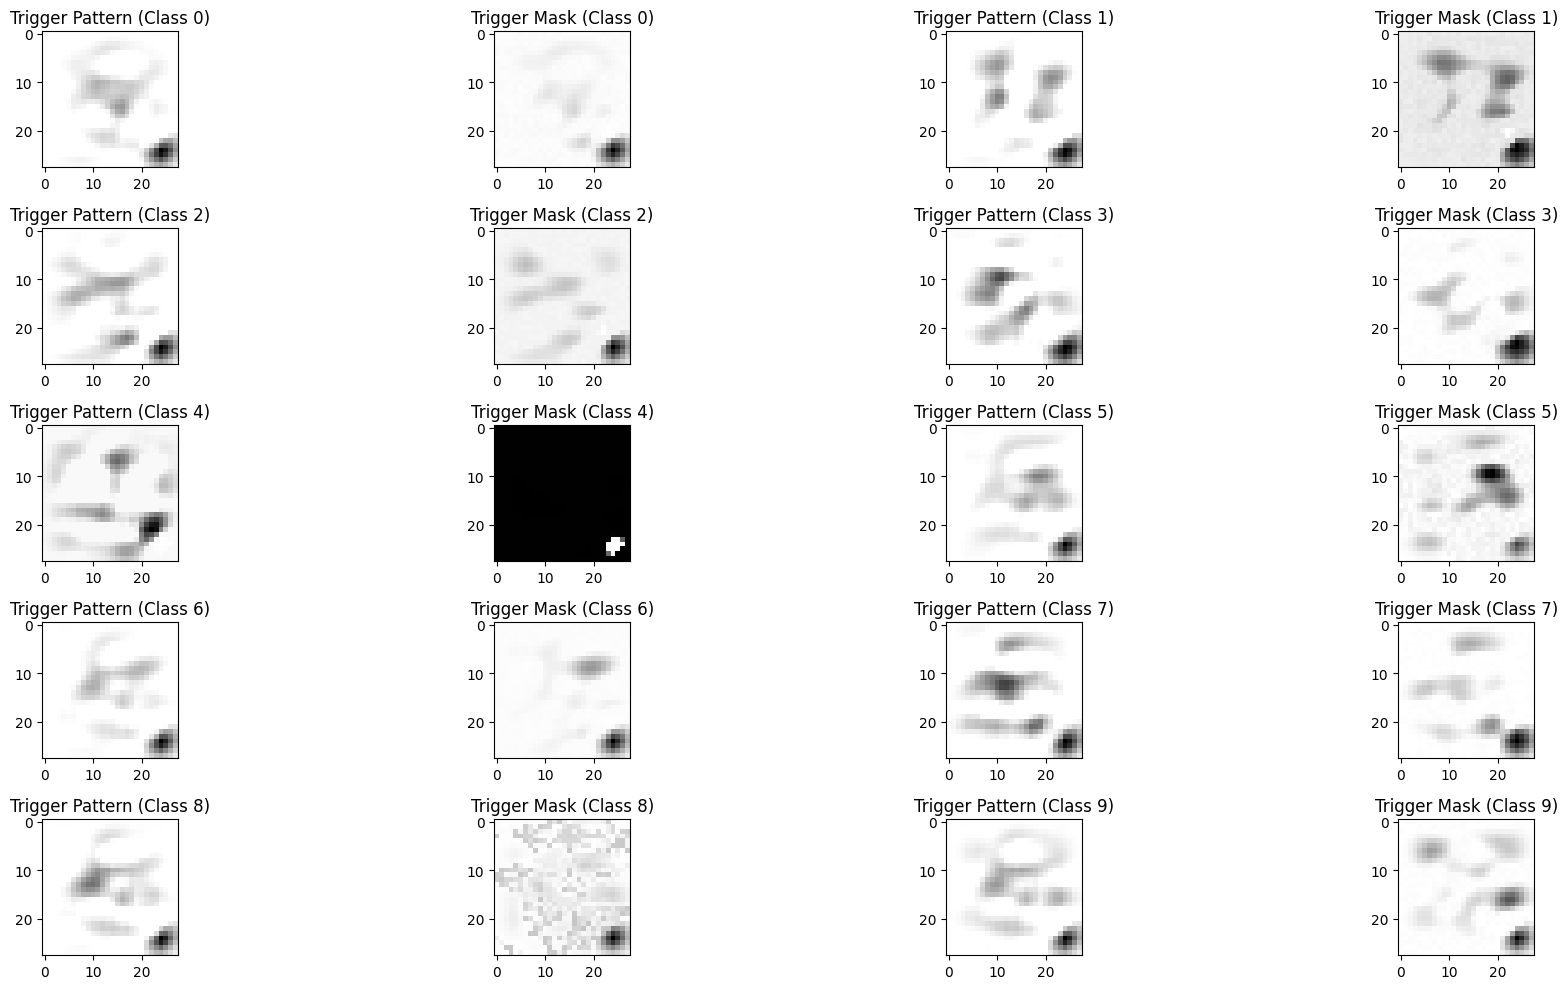

In [11]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(5, 4, 2 * i + 1)
    plt.title(f"Trigger Pattern (Class {i})")
    plt.imshow(patterns[i].squeeze(), cmap='gray')

    plt.subplot(5, 4, 2 * i + 2)
    plt.title(f"Trigger Mask (Class {i})")
    plt.imshow(masks[i].squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

In [73]:
anomaly_scores = [np.sum(np.abs(mask)).item() for mask in masks]

median_score = np.median(anomaly_scores)
mad = np.median([abs(score - median_score) for score in anomaly_scores])

scaled_mad = mad * 1.4826

threshold = median_score + 2 * scaled_mad

attacked_labels = [i for i, score in enumerate(anomaly_scores) if score > threshold]

print(f'Potentially attacked labels: {attacked_labels}')



Potentially attacked labels: [4]


### unlearning

In [56]:

# Create model instance
model = MyModel()

model_path = '/content/poisened_model_4.pth'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model = model.to('cuda')
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
data_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=False)



In [65]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in data_loader:
        images = images.to('cuda') 
        labels = labels.to('cuda') 


        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Accuracy of the model on the test set: 72.48%


In [66]:
mask, pattern = neural_cleanse(model, data_loader, 4, lambda_reg=0.01)

In [67]:
specified_class = 4

class CustomMNIST(Dataset):
    def __init__(self, original_dataset, mask, pattern, specified_class):
        self.original_dataset = original_dataset
        self.mask = torch.tensor(mask, dtype=torch.float32).to('cuda')
        self.pattern = torch.tensor(pattern, dtype=torch.float32).to('cuda')
        self.specified_class = specified_class

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        image = image.to('cuda')
        modified_image = image * (1-self.mask) + self.mask*self.pattern
        modified_label = self.specified_class
        return modified_image, modified_label


custom_dataset = CustomMNIST(mnist_dataset, mask, pattern, specified_class)

custom_data_loader = DataLoader(custom_dataset, batch_size=64, shuffle=False)


<ipython-input-67-d82ff31fd80f>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32).to('cuda')
<ipython-input-67-d82ff31fd80f>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pattern = torch.tensor(pattern, dtype=torch.float32).to('cuda')


In [68]:
model.eval()

correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in custom_data_loader:
        images = images.to('cuda') # Move input to GPU
        labels = labels.to('cuda') # Move labels to GPU

        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Accuracy of the model on the test set: 98.53%


In [74]:
specified_class = 4

probability_threshold = 0.2

class CustomMNIST(Dataset):
    def __init__(self, original_dataset, mask, pattern, specified_class, probability_threshold):
        self.original_dataset = original_dataset
        self.mask = torch.tensor(mask, dtype=torch.float32).to('cuda')
        self.pattern = torch.tensor(pattern, dtype=torch.float32).to('cuda')
        self.specified_class = specified_class
        self.probability_threshold = probability_threshold

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        image = image.to('cuda')

        if torch.rand(1).item() < self.probability_threshold:
            modified_image = image * (1-self.mask) + self.mask*self.pattern
            modified_label = label
        else:
            modified_image = image
            modified_label = label

        return modified_image, modified_label

custom_dataset_mixed = CustomMNIST(mnist_dataset, mask, pattern, specified_class, probability_threshold)

custom_data_loader_mixed = DataLoader(custom_dataset_mixed, batch_size=64, shuffle=True)


<ipython-input-74-4573f8ee7868>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32).to('cuda')
<ipython-input-74-4573f8ee7868>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pattern = torch.tensor(pattern, dtype=torch.float32).to('cuda')


In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 1
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in custom_data_loader_mixed:

        images, labels = images.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(custom_data_loader_mixed):.4f}")

print('Finished Training')

Epoch [1/1], Loss: 1.5750
Finished Training


In [71]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in data_loader:

        images = images.to('cuda') # Move input to GPU
        labels = labels.to('cuda') # Move labels to GPU

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Accuracy of the model on the test set: 95.80%


In [72]:
import torch

model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in custom_data_loader:
        images = images.to('cuda') # Move input to GPU
        labels = labels.to('cuda') # Move labels to GPU

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Accuracy of the model on the test set: 9.60%
